In [1]:
# Import libraries
import pandas as pd
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.dummy import DummyClassifier

# classifiers
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB

# evaluation
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

from scipy.stats import chisquare, chi2_contingency

In [2]:
# load datasest
df = pd.read_excel("./data/2nd_Dataset_IgM_Rapid_Test-ELISA_Raw_Data.xlsx", header=0, comment="#")
len(df)

106

In [10]:
df

,lab-ID,Gender,Age,IgM/Pos.,IgM/b-intin.,IgM/b-intin. value,E-IgM/ODs,E-IgM/Pos.,E-IgM/Ods,E-IgM/Pos..1,IgM,IgM.1,Symptoms,Age bin,status,target
0,LSS-1,M,54,P,F,10,0.383,N,0.383,N,5.4,7.7,"Headache, sorethroat",50s,LSS,1
1,LSS-2,F,45,N,no,0,0.425,N,0.425,N,6.0,8.5,no,40s,LSS,0
2,LSS-3,F,37,N,no,0,0.363,N,0.363,N,5.1,7.3,"Fatigue, headache, abdominal pain, diarrhoea",30s,LSS,1
3,LSS-4,M,40,N,no,0,0.498,N,0.498,P,7.0,10.0,no,40s,LSS,0
4,LSS-5,M,50,N,no,0,0.363,N,0.363,N,5.1,7.3,no,50s,LSS,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99,HSS-100,F,30,N,no,0,0.640,N,0.640,P,9.1,13.0,no,30s,HSS,0
100,HSS-101,M,58,N,no,0,0.398,N,0.398,N,5.5,7.9,"Faver, fatigue, dyspnea, myalgia, headache",50s,HSS,1
101,HSS-102,F,40,N,no,0,0.560,N,0.560,P,7.1,11.4,"Sorthroat, headache",40s,HSS,1
102,HSS-103,F,37,P,VF,5,0.318,N,0.318,N,4.4,6.3,Sorthroat,30s,HSS,1


In [3]:
# further cleanup
indexNames = df[df['Age'] == 'NS'].index
 
# Delete these row indexes from dataFrame
df.drop(indexNames , inplace=True)

# set age to numeric
df["Age"] = df["Age"].astype(int)

# bin ages
df["Age bin"] = pd.cut(x=df['Age'], 
                       bins=[10, 20, 29, 39, 49, 59, 69, 79, 89], 
                       labels=['10s', '20s', '30s', '40s', '50s','60s', '70s', '80s'])

# remove unwanted spaces

df[" IgM/Pos."] = df[" IgM/Pos."].str.replace(' ', '')

In [4]:
# remove empty cells
df = df.dropna(axis=0)
len(df)

87

In [5]:
# create class column
def get_class(row):
    wanted = row["lab-ID"]
    return wanted.split("-")[0]

df["status"] = df.apply(get_class, axis=1)

# create target column
def encode_symptoms(row):
    wanted = row["Symptoms"]
    if str(wanted) == "no":
        return 0
    return 1

df["target"] = df.apply(encode_symptoms, axis=1)

In [6]:
# visualize if measurements are indeed equal transformations
temp_df = df[["E-IgM/ODs", " IgM", " IgM.1"]]
temp_df.corr().style.background_gradient(cmap="Blues")

,E-IgM/ODs,IgM,IgM.1
E-IgM/ODs,1.000000,0.999248,0.961280
IgM,0.999248,1.000000,0.960344
IgM.1,0.961280,0.960344,1.000000


array([[<AxesSubplot:title={'center':'E-IgM/ODs'}>]], dtype=object)

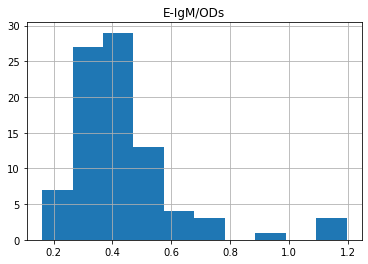

In [51]:
# visualize distributions of measurements
df.hist("E-IgM/ODs")

array([[<AxesSubplot:title={'center':'Age'}>]], dtype=object)

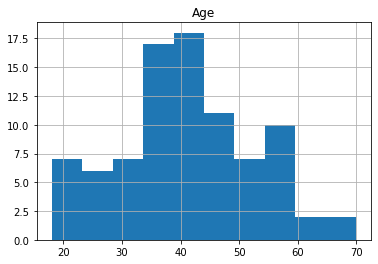

In [52]:
df.hist("Age")

<AxesSubplot:xlabel='status', ylabel='E-IgM/ODs'>

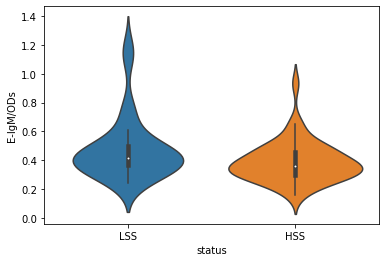

In [63]:
sns.violinplot(y="E-IgM/ODs", x="status", data=df)

<AxesSubplot:xlabel='target', ylabel='E-IgM/ODs'>

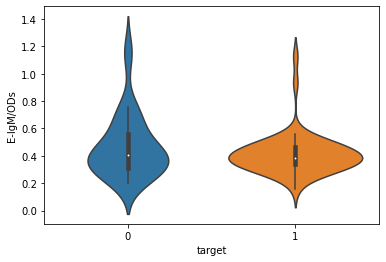

In [12]:
sns.violinplot(y="E-IgM/ODs", x="target", data=df)

In [14]:
high_od = df[df["E-IgM/ODs"] > 0.5]

In [18]:
low_od  = df[df["E-IgM/ODs"] < 0.5]

In [21]:
len(low_od[low_od["Symptoms"] == "no"])

25

In [23]:
low_od[low_od["Symptoms"] != "no"]

,lab-ID,Gender,Age,IgM/Pos.,IgM/b-intin.,IgM/b-intin. value,E-IgM/ODs,E-IgM/Pos.,E-IgM/Ods,E-IgM/Pos..1,IgM,IgM.1,Symptoms,Age bin,status,target
0,LSS-1,M,54,P,F,10,0.383,N,0.383,N,5.4,7.7,"Headache, sorethroat",50s,LSS,1
2,LSS-3,F,37,N,no,0,0.363,N,0.363,N,5.1,7.3,"Fatigue, headache, abdominal pain, diarrhoea",30s,LSS,1
5,LSS-6,F,34,N,no,0,0.456,N,0.456,N,6.4,9.1,"Fever, fatigue,dyspnea, headache, nausea/vomit...",30s,LSS,1
8,LSS-9,F,36,N,no,0,0.465,N,0.465,N,6.5,9.3,"Fever, fatigue, myalgia, abdominal pain, rhino...",30s,LSS,1
9,LSS-10,F,42,N,no,0,0.372,N,0.372,N,5.2,7.5,"Cough, rhinorrea",40s,LSS,1
11,LSS-12,F,36,P,F,10,0.445,N,0.445,N,6.2,8.9,"Fever, dyspnea, headache, sorethroat, Cough, a...",30s,LSS,1
12,LSS-13,M,18,N,no,0,0.412,N,0.412,N,5.8,8.3,"Fatigue, dyspnea,myalgia, headache, sorethroat...",10s,LSS,1
13,LSS-14,M,57,N,no,0,0.464,N,0.464,N,6.5,9.3,Anosmia,50s,LSS,1
14,LSS-15,M,57,P,VF,5,0.296,N,0.296,N,4.1,5.9,"Fever, sorethroat, fatigue",50s,LSS,1
15,LSS-16,F,40,N,no,0,0.496,N,0.496,N,7.0,10.0,Sorethroat,40s,LSS,1


In [25]:
high_od_rapid_test = df[df["IgM/b-intin. value"] >= 10]

In [26]:
high_od_rapid_test

,lab-ID,Gender,Age,IgM/Pos.,IgM/b-intin.,IgM/b-intin. value,E-IgM/ODs,E-IgM/Pos.,E-IgM/Ods,E-IgM/Pos..1,IgM,IgM.1,Symptoms,Age bin,status,target
0,LSS-1,M,54,P,F,10,0.383,N,0.383,N,5.4,7.7,"Headache, sorethroat",50s,LSS,1
11,LSS-12,F,36,P,F,10,0.445,N,0.445,N,6.2,8.9,"Fever, dyspnea, headache, sorethroat, Cough, a...",30s,LSS,1
17,LSS-18,F,41,P,F,10,0.366,N,0.366,N,5.1,7.3,Sorethroat,40s,LSS,1
18,LSS-19,F,40,P,F,10,0.757,P,0.757,P,10.7,15.3,no,40s,LSS,0
20,LSS-21,F,23,P,F,10,0.398,N,0.398,N,5.5,7.9,"Faver, abdominal pain, myalgia, headache",20s,LSS,1
23,LSS-24,M,58,P,F,10,0.414,N,0.414,N,5.8,8.3,no,50s,LSS,0
29,LSS-30,F,55,P,F,10,1.130,P,1.130,P,16.1,23.0,"Cough, myalgia, fatigue",50s,LSS,1
30,LSS-31,F,44,P,S,100,0.552,N,0.552,P,7.8,11.2,"Dizziness, blurred vision, headache, fatigue",40s,LSS,1
56,HSS-57,M,54,P,F,10,0.497,N,0.497,P,7.0,10.0,"Fatigue, sorthroat, myalgia",50s,HSS,1
69,HSS-70,M,30,P,F,10,0.347,N,0.347,N,4.8,5.7,Headache,30s,HSS,1


<AxesSubplot:xlabel='Gender', ylabel='count'>

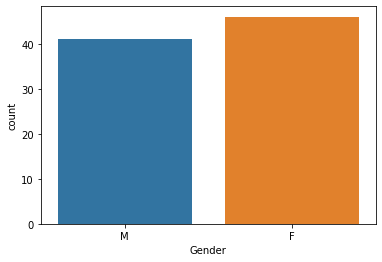

In [76]:
sns.countplot(x="Gender", data=df)

<AxesSubplot:xlabel='Age bin'>

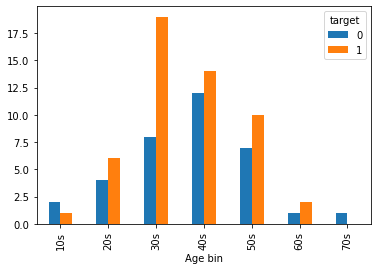

In [80]:
pd.crosstab(df["Age bin"], df["target"]).plot(kind="bar")
# todo: include the numbers on top of the column

<AxesSubplot:xlabel='Gender'>

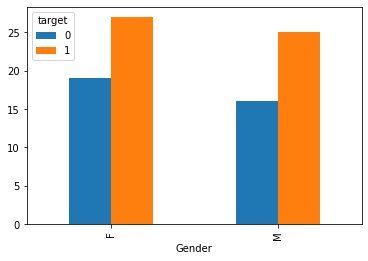

In [81]:
pd.crosstab(df["Gender"], df["target"]).plot(kind="bar")

<AxesSubplot:xlabel='status'>

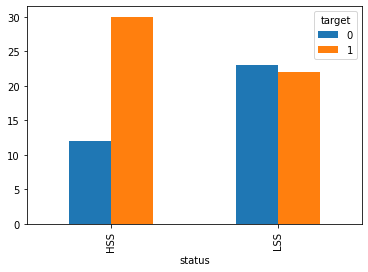

In [82]:
pd.crosstab(df["status"], df["target"]).plot(kind="bar")

<AxesSubplot:xlabel='E-IgM/Pos.'>

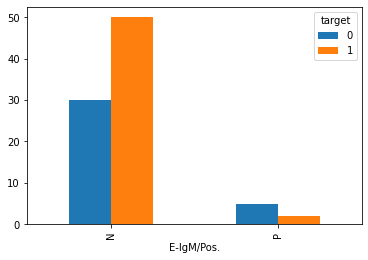

In [9]:
pd.crosstab(df["E-IgM/Pos."], df["target"]).plot(kind="bar")

<AxesSubplot:xlabel='E-IgM/Pos..1'>

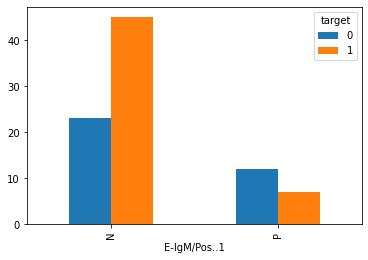

In [11]:
pd.crosstab(df["E-IgM/Pos..1"], df["target"]).plot(kind="bar")

<AxesSubplot:xlabel=' IgM/Pos.'>

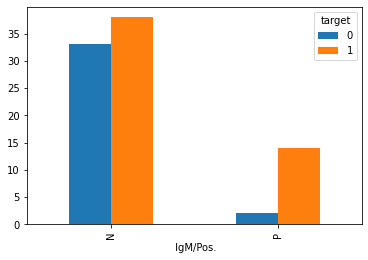

In [87]:
pd.crosstab(df[" IgM/Pos."], df["target"]).plot(kind="bar")

In [8]:
# Random forest classifier

# target 
targets = df["target"].values

# encodings

# bulk encodings

wanted_columns = ['Gender', ' IgM/Pos.', 
                  ' IgM/b-intin.', 'status',
                  'Age bin']
df_wanted = df[wanted_columns]

le = LabelEncoder()
df_wanted_le = df_wanted.apply(le.fit_transform)

ohe = OneHotEncoder()
ohe.fit(df_wanted_le)
input_df = ohe.transform(df_wanted_le).toarray()
input_df.shape

# Generate training and test sets

X_train, X_test, y_train, y_test = train_test_split(input_df,
                                                    targets,
                                                    random_state=42)

# Benchmark with dummy classifier

dummy_clf = DummyClassifier(strategy="stratified")
dummy_clf.fit(X_train, y_train)
print("dummmy score: {}".format(dummy_clf.score(X_test, y_test)))

# Random forest model

model = RandomForestClassifier(n_jobs=2, random_state=42)
model.fit(X_train, y_train)
print("RF accuracy: {}".format(model.score(X_test, y_test)))
    

dummmy score: 0.45454545454545453
RF accuracy: 0.5454545454545454


In [25]:
# Logistic regression
from sklearn.linear_model import LogisticRegression


# only numerical variable
dependent_var = ["E-IgM/Ods"]
X_train, X_test, y_train, y_test = train_test_split(df[dependent_var].values ,
                                                    df["target"].values,
                                                    random_state=42)
clf = LogisticRegression(random_state=0).fit(X_train, y_train)
print("LR_numerical: {}".format(clf.score(X_test, y_test)))

# all categorical variables
new_df = pd.get_dummies(df_wanted, drop_first=True)
X_train, X_test, y_train, y_test = train_test_split(new_df.values ,
                                                    df["target"].values,
                                                    random_state=42)
clf = LogisticRegression(random_state=0).fit(X_train, y_train)
print("LR_categorical: {}".format(clf.score(X_test, y_test)))

# both
new_df["E-IgM/Ods"] = df["E-IgM/Ods"]
X_train, X_test, y_train, y_test = train_test_split(new_df.values ,
                                                    df["target"].values,
                                                    random_state=42)
clf = LogisticRegression(random_state=0).fit(X_train, y_train)
print("LR_both: {}".format(clf.score(X_test, y_test)))


LR_numerical: 0.6363636363636364
LR_categorical: 0.6818181818181818
LR_both: 0.6818181818181818


In [57]:
# t test

from scipy import stats
hss = df[df["status"] == "HSS"]["E-IgM/Ods"]
lss = df[df["status"] == "LSS"]["E-IgM/Ods"]

t_test = stats.ttest_ind(hss, lss)
t_test

Ttest_indResult(statistic=-2.222176288493547, pvalue=0.02892730300973166)